In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-15 14:42:59.149845: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/Dataset/dataset_3/training"
val_path = "/drive0-storage/Gracia/Dataset/dataset_3/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 14:43:01.463813: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 14:43:02.260177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [ ]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 244.90761
(184, 216, 3)


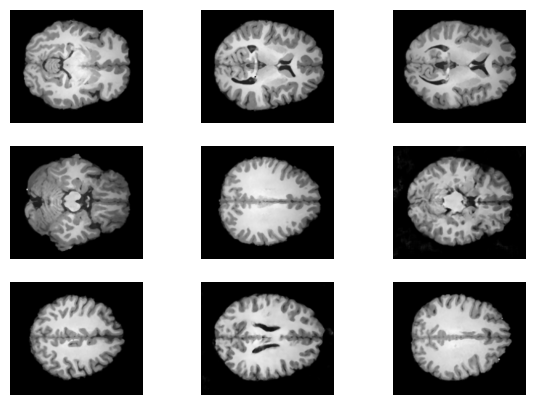

In [5]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [5]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
print(len(test_dataset))

64
64


## Model building

In [7]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [9]:
with tf.device("GPU"):
    model = build_vgg16()

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [8]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn3_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [10]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 14:43:42.676646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 14:43:43.688528: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


511/511 [==============================] - 31s 54ms/step - loss: 1.0856 - accuracy: 0.4020 - val_loss: 1.1039 - val_accuracy: 0.3745
Epoch 2/30
511/511 [==============================] - 27s 52ms/step - loss: 0.9557 - accuracy: 0.5246 - val_loss: 0.9991 - val_accuracy: 0.5020
Epoch 3/30
511/511 [==============================] - 27s 52ms/step - loss: 0.7665 - accuracy: 0.6340 - val_loss: 0.9454 - val_accuracy: 0.5285
Epoch 4/30
511/511 [==============================] - 27s 52ms/step - loss: 0.6474 - accuracy: 0.7085 - val_loss: 0.8027 - val_accuracy: 0.6373
Epoch 5/30
511/511 [==============================] - 27s 52ms/step - loss: 0.5310 - accuracy: 0.7644 - val_loss: 0.7632 - val_accuracy: 0.6240
Epoch 6/30
511/511 [==============================] - 27s 52ms/step - loss: 0.3792 - accuracy: 0.8436 - val_loss: 0.5081 - val_accuracy: 0.7766
Epoch 7/30
511/511 [==============================] - 26s 52ms/step - loss: 0.2540 - accuracy: 0.9025 - val_loss: 0.5954 - val_accuracy: 0.7771
Epo

In [11]:
model.save('./models/cnn3_21epoch.h5')

### Training evaluation

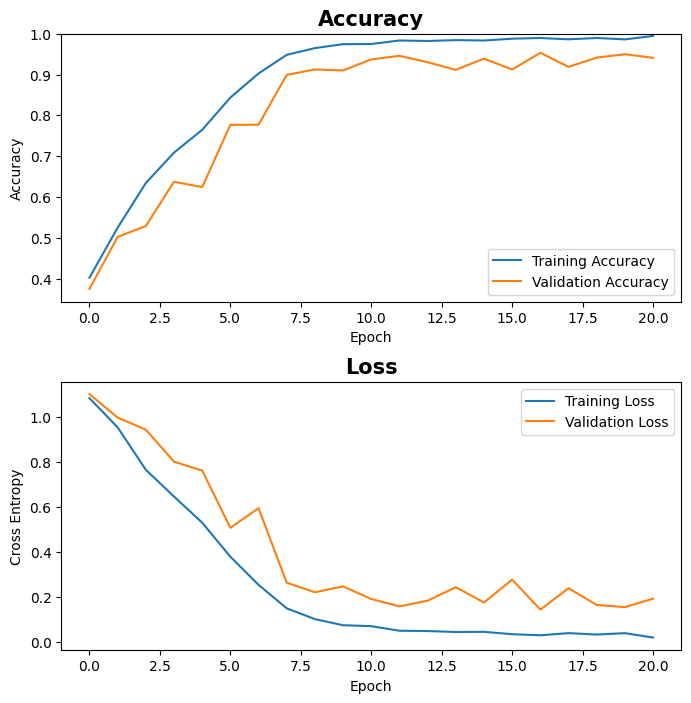

In [12]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [13]:
acc

[0.40197157859802246,
 0.5246142745018005,
 0.6339701414108276,
 0.7085476517677307,
 0.764388918876648,
 0.843558669090271,
 0.9025226831436157,
 0.9482610821723938,
 0.9647318124771118,
 0.9744672775268555,
 0.9747734665870667,
 0.9834067821502686,
 0.9822434186935425,
 0.9843252301216125,
 0.9833455681800842,
 0.9878765344619751,
 0.989468514919281,
 0.986284613609314,
 0.9895297288894653,
 0.9861009120941162,
 0.9945505857467651]

In [14]:
val_acc

[0.374507874250412,
 0.501968502998352,
 0.5285432934761047,
 0.6373031735420227,
 0.624015748500824,
 0.7765747904777527,
 0.7770669460296631,
 0.899114191532135,
 0.912401556968689,
 0.9099409580230713,
 0.9370078444480896,
 0.9458661675453186,
 0.9301180839538574,
 0.9114173054695129,
 0.9389764070510864,
 0.912401556968689,
 0.9532480239868164,
 0.9187992215156555,
 0.9414370059967041,
 0.9498031735420227,
 0.9409449100494385]

In [15]:
loss

[1.085607647895813,
 0.9556788802146912,
 0.7665495276451111,
 0.6473942995071411,
 0.5310108065605164,
 0.3792451322078705,
 0.2539787292480469,
 0.14937178790569305,
 0.10132917016744614,
 0.07411928474903107,
 0.06988776475191116,
 0.049557384103536606,
 0.04813661053776741,
 0.04407939314842224,
 0.044582799077034,
 0.0341656431555748,
 0.02928142435848713,
 0.038928013294935226,
 0.03260606899857521,
 0.038708388805389404,
 0.01920613832771778]

In [16]:
val_loss

[1.1038708686828613,
 0.9990704655647278,
 0.9454266428947449,
 0.8027043342590332,
 0.7632334232330322,
 0.5080567002296448,
 0.5953704118728638,
 0.2634768486022949,
 0.22094164788722992,
 0.24708960950374603,
 0.19084331393241882,
 0.1581825315952301,
 0.18347090482711792,
 0.24335935711860657,
 0.17539244890213013,
 0.27736005187034607,
 0.14379991590976715,
 0.23900948464870453,
 0.16439738869667053,
 0.15457889437675476,
 0.19234676659107208]

## Testing

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [18]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 1s 20ms/step - loss: 0.2166 - accuracy: 0.9302


{'loss': 0.21655650436878204, 'accuracy': 0.93017578125}

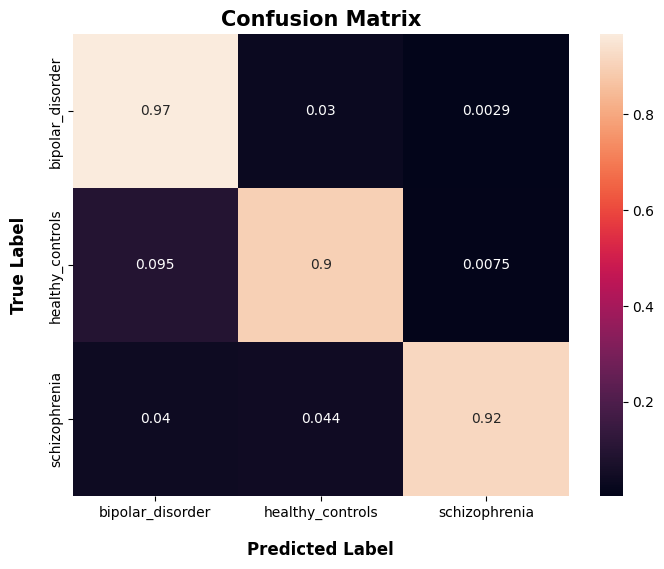

In [19]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN3_cm.png')
plt.show()

In [20]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.93017578125
Precision: 0.9306558782644527
Sensitivity: 0.927734375
Specificity: 0.9635897341739404
